In [2]:
import hublib
import pandas as pd
import ipywidgets as widgets
from IPython.display import clear_output
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy
import numpy as np
from decimal import Decimal
import unicodedata
from unicodedata import lookup as GL
import sympy as sy
from joblib import Parallel, delayed
from lmfit import Model
import warnings
import zipfile
from zipfile import ZipFile
import os
#from hublib.io import FileUpload, Download

In [ ]:
class Spectrum:
    def __init__(self):
        self.x=0
        self.y=0
        self.I=[]
        self.W=[]
        self.If=[]
        self.PG=[]
        self.PGp=[]
        self.PD=[]
        self.IDfit=[]
        self.Q=0
        self.diffs=[]
        self.mdi=0
        self.md=0
        self.mf=[]

In [ ]:
global Specs
Specs=[]

global filelist
filelist = []

global cfl

In [ ]:
def mycb(w,fnames):
    global fnm
    fnm=fnames[0]
    fbase = os.path.basename(fnm)
    os.makedirs('data/' + os.path.splitext(fbase)[0])
    filelist.append(fbase)
    os.rename(fnm, 'data/raw/' + fbase)
    w.reset()

f = FileUpload("Please upload Raman spectra data file (CSV)", 
               "Raman data files should be uploaded as 2 column CSV files",
               cb=mycb,
               maxsize=10000000)
f

In [ ]:
def errprint(code):
    errfile=pd.read_csv('errfile.txt',sep='\t',header=None)
    with errout:
        clear_output()
        print(errfile[0][code])
        fit_but.disabled=False
        errout

In [ ]:
def case_lookup(index):
    casefile=pd.read_csv('Case_List.txt',sep='\t',header=None)
    c=casefile[0][index]
    return c

In [ ]:
fit_but = widgets.Button(description='Do Fitting')
    
def fit_but_cb(change):
    global cfl
    fit_but.disabled=True
    param.disabled=True
    with plist:
        clear_output()
        print('Reading data files...')
    with errout:
        clear_output()
    with diffsplot:
        clear_output()
    with datplot:
        clear_output()
    
    for flnm in filelist:
        cfl = flnm
        if flnm[-3:]=='txt':
            sp='\s+'
        elif flnm[-3:]=='csv':
            sp=','
        else:
            errprint(0)
            return
        try:
            data = pd.read_csv('data/raw/' + flnm,sep=sp,header=None)
        except:
            sp='\t'
            data = pd.read_csv('data/raw/' + flnm,sep=sp,header=None)
        with plist:
            clear_output()
            print('Data file read')

        n=int(data.size/len(data)) #n determines the size of the data file

        global Specs
        Specs.clear()

        ##Single Spectra Data File, n=2    
        if n==2:
            with plist:
                clear_output()
                print('Fitting single spectra data.')

            s=Spectrum()
            Spectra(s,data)
            Fit(s)

            dtplot(s)

            with diffsplot:
                clear_output()
                fig=plt.figure(figsize=(4,4))
                ax=fig.add_subplot(111)
                plt.plot(s.diffs,'kv')
                plt.plot(s.mdi,s.md,'gv')
                plt.annotate((round(Decimal(s.md),2)),xy=(s.mdi,1.2*s.md))
                plt.xticks(range(6),('1','2','3','4','5','Graphite'))
                plt.xlabel('# Layers')
                plt.ylabel('$\Delta$ [%]')
                plt.show()

            save_spec(s)
            zip_files('data')
            params_print(s)

        #Map files will be much larger than 2 points and need separate handling
        elif n > 2:
            Specs=[]
            Map(data)
        else:
            errprint(1)
            return
    fit_but.disabled=False

fit_but.on_click(fit_but_cb)
fit_but

In [ ]:
def Map(data): 
    W=data[:][0:1]
    W=np.array(W)
    W=W[~np.isnan(W)]
    
    x=data[0]
    x=np.array(x)
    x=x[~np.isnan(x)]
    xu=np.unique(x)
    
    y=data[1]
    y=np.array(y)
    y=y[~np.isnan(y)]
    yu=np.unique(y)
    
    n=yu.size*xu.size
    
    s=Spectrum()
    
    Parallel(n_jobs=1)(delayed(maploop)(s,Specs,data,W,x,y,n,k) for k in range(n))
    
    wG=np.transpose(np.array([o.PG for o in Specs]))[2]      
    
    Mplot(x,y,wG,'$\omega_G$ $[cm^{-1}]$','wG')
    Hplot(wG,'$\omega_G$ $[cm^{-1}]$','wG')
    
    with plist:
        clear_output()
        print('Fitting Finished')
    save_map(Specs)
    zip_files('data')
    with plist:
        clear_output()
    param.disabled=False

In [ ]:
def maploop(s,Specs,data,W,x,y,n,k):
    s=Spectrum()
        
    I_raw=np.array(data)[k+1][2:1026]
    tmp_min = np.min(I_raw)
    I_tmp = I_raw-tmp_min
    tmp_max = np.max(I_tmp)
    I=I_tmp/tmp_max
    #I=((I_raw-np.min(I_raw))/np.max(I_raw-np.min(I_raw)))
    s.I=I
    s.W=W
    s.x=x[k]
    s.y=y[k]
    Fit(s)
    Specs.append(s)

    pdone=100*(k+1)/n

    with plist:
        clear_output()
        print('Fitting map data. This may take some time...\n%1.2f%% Done'%(pdone))

    return Specs

In [ ]:
def Spectra(s,data):
    srow=0;
    if type(data[0][0])==str:
        srow=1
    
    W=data[0][srow:len(data)]
    W=np.array(W);W=W.astype(float)
    I_raw=data[1][srow:len(data)]
    I_raw=np.array(I_raw);I_raw=I_raw.astype(float)

#background fitting could be done, but it sometimes messes up some spectra
#in general, the hope is that the specra will not need it
    
    polyx=np.array([W[0],W[int(len(W)/2)],W[len(W)-1]])
    polyy=np.array([I_raw[0],I_raw[int(len(W)/2)],I_raw[len(W)-1]])        
    bkgfit=np.polyfit(polyx,polyy,2)
    bkgpoly=(bkgfit[0]*W**2)+(bkgfit[1]*W)+bkgfit[2]
    I_raw=I_raw-bkgpoly
    
    m=(I_raw[len(W)-1]-I_raw[0])/(W[len(W)-1]-W[0])
    b=I_raw[len(W)-1]-m*W[len(W)-1]
    bkglin=m*W+b
    
    I_raw=I_raw-bkglin
    
    I=((I_raw-np.min(I_raw))/np.max(I_raw-np.min(I_raw)));
    
    
    s.I=I
    s.W=W
    return s

In [ ]:
def Fit(s):
    W=s.W
    I=s.I
    pG=[1.1*np.max(I), 50, 1581.6] #a w b
    pGp=[1.1*np.max(I), 50, 2675]

    L.set_bounds([1.5*np.max(I),60,2000],[0.3*np.max(I),33,1400])
    PGm=L.fit(s.W,s.I,pG)
    
    L.set_bounds([1.5*np.max(I),60,3000],[0.3*np.max(I),32,2000])
    PGpm=L.fit(s.W,s.I,pGp)
    
    PG=np.array(list(PGm.best_values.values()))
    PGp=np.array(list(PGpm.best_values.values()))
    
    PG[1]=np.absolute(PG[1]);PGp[1]=np.absolute(PGp[1]); #FWHM sometimes returns - bc always squared
    
    IGfit=Single_Lorentz(W,PG[0],PG[1],PG[2]);
    IGpfit=Single_Lorentz(W,PGp[0],PGp[1],PGp[2]);
    IGfit=IGfit
    IGpfit=IGpfit
    s.If=IGfit+IGpfit;
    
    s.PG=PG
    s.PGp=PGp
    
    pD=[0.1*np.max(I),5,1350]

    L.set_bounds([np.max(I),50,1400],[0,10,1300])
    PDm=L.fit(s.W,s.I,pD)
    PD=np.array(list(PDm.best_values.values()))
    PD[1]=np.absolute(PD[1]);
    IDfit=Single_Lorentz(W,PD[0],PD[1],PD[2]);
    s.IDfit=IDfit
    Q=1-(PD[0]/PG[0])
    s.Q=Decimal(Q)
    s.PD=PD
    
    Cdat=np.load('Cfits.npy')

    diffs_lin=[];diffs_Gp=[];
    diffs=[];diffs.clear()
    for d in range(6):
        
        LG=Cdat[d][0];LG=np.transpose(LG)[0]
        LGp=Cdat[d][1];LGp=np.transpose(LGp)[0]
        LGfit=Single_Lorentz(W,LG[0],LG[1],LG[2]); 
        LGpfit=Single_Lorentz(W,LGp[0],LGp[1],LGp[2]);
        Lf=(LGfit+LGpfit)
 
        wts=[1.,1.,0.5]
        
        dfGp=np.average(np.absolute(100*(PGp-LGp)/LGp),weights=wts)
        dfG=np.average(np.absolute(100*(PG-LG)/LG),weights=wts)
        drat=np.absolute(100*(((PG[0]/PGp[0])-(LG[0]/LGp[0]))/(LG[0]/LGp[0])))
        df=np.average([dfGp,dfG,drat],weights=[0.5,0.5,1])
        diffs.append(df)
    
    s.diffs=diffs
    md=np.min(diffs)
    mdi=np.argmin(diffs)

    mG=Cdat[mdi][0];mGp=Cdat[mdi][1];
    mGfit=Single_Lorentz(W,mG[0],mG[1],mG[2]);
    mGpfit=Single_Lorentz(W,mGp[0],mGp[1],mGp[2]);
    mf=mGfit+mGpfit
    s.mf=mf
    s.md=md
    s.mdi=mdi
    return s

In [ ]:
def Single_Lorentz(x,a,w,b):
    return a*(((w/2)**2)/(((x-b)**2)+((w/2)**2)))

In [ ]:
def dtplot(s):
        with datplot:
            clear_output()
            fig1=plt.figure(figsize=(4,4))
            ax=fig1.add_subplot(111)
            plt.plot(s.W,s.I,'b',s.W,s.mf,'g',s.W,s.If+s.IDfit,'r')
            plt.xlabel('$\omega$ $[cm^{-1}]$')
            plt.ylabel('$I_{norm}$ [arb]')
            plt.legend(labels=['Raw','Test','Fit'])
            plt.annotate('Q=%1.2f' %round(s.Q,2) ,xy=(np.min(s.W),0.98))
            plt.annotate('D',xy=(0.85*s.PD[2],1.1*s.PD[0]))
            plt.annotate('G',xy=(0.9*s.PG[2],0.95*s.PG[0]))
            plt.annotate('G\'',xy=(0.94*s.PGp[2],0.95*s.PGp[0]))
            plt.show()
            plt.savefig('data/'+cfl[:-4]+'/specs.png')

In [ ]:
def dfplot(s):
    with diffsplot:
        clear_output()
        fig=plt.figure(figsize=(4,4))
        ax=fig.add_subplot(111)
        plt.plot(s.W,s.I,'b',s.W,s.mf,'g',s.W,s.If+s.IDfit,'r')
        plt.xlabel('$\omega$ $[cm^{-1}]$')
        plt.ylabel('$I_{norm}$ [arb]')
        plt.legend(labels=['Raw','Test','Fit'])
        plt.annotate('Q=%1.2f' %round(s.Q,2) ,xy=(np.min(s.W),0.98))
        plt.annotate('D',xy=(0.85*s.PD[2],1.1*s.PD[0]))
        plt.annotate('G',xy=(0.9*s.PG[2],0.95*s.PG[0]))
        plt.annotate('G\'',xy=(0.94*s.PGp[2],0.95*s.PGp[0]))
        plt.show()
    params_print(s)

In [ ]:
def Mplot(x,y,z,d,fn):
    global p,point,datax
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    
    with datplot:
        clear_output()
        Z=matplotlib.mlab.griddata(x, y, z, xi, yi, interp='linear') 
        fig=plt.figure(figsize=(4,4))
        datax=fig.add_subplot(111)
        p,=datax.plot([],[],'o')
        point=pickPeaks(p)
        C=plt.contourf(X,Y,Z)
        plt.set_cmap('inferno')
        plt.xlabel('x [mm]')
        plt.ylabel('y [mm]')
        #datax.set_xlim(np.min(xi),np.max(xi))
        #datax.set_ylim(np.min(yi),np.max(yi))
        plt.title(d)
        plt.colorbar(C)
        plt.axis('off')
        #datax.autoscale
        plt.show()
        figname = 'data/'+ cfl[:-4]+'/' + fn + '_map.png'
        plt.savefig(figname)
        mout = open('data/'+ cfl[:-4]+'/' + fn + '_dat.map','w')
        mout.write(' '.join(str(n) for n in Z))

In [ ]:
def Hplot(z,d,fn):
    with plist:
        clear_output()
    with diffsplot:
        clear_output()
        fig=plt.figure(figsize=(4,4))
        ax=fig.add_subplot(111)
        plt.hist(z,bins='auto')
        plt.ylabel('Counts')
        plt.xlabel(d)
        plt.show()
        figname = 'data/'+ cfl[:-4]+'/' + fn + '_hist.png'
        plt.savefig(figname)
        hout = open('data/'+ cfl[:-4]+'/' + fn + '_dat.hist','w')
        hout.write(' '.join(str(n) for n in z))

In [ ]:
def params_print(s):
    with plist:
        clear_output()
        G=GL('GREEK CAPITAL LETTER GAMMA')
        o=GL('GREEK SMALL LETTER OMEGA')
        print('G Fitting Parameters:\n\tA=%1.2f\n\t%s=%1.2f\n\t%s=%1.2f\n'
              'G\' Fitting Parameters:\n\tA=%1.2f\n\t%s=%1.2f\n\t%s=%1.2f\n'
              'D Fitting Parameters:\n\tA=%1.2f\n\t%s=%1.2f\n\t%s=%1.2f\n'
              'Quality=%1.2f (Ratio of D to G)\n'
              'Best Case Match: %s'
              %(s.PG[0],G,s.PG[1],o,s.PG[2],s.PGp[0],G,s.PGp[1],o,s.PGp[2],s.PD[0],G,s.PD[1],o,s.PD[2],s.Q,case_lookup(s.mdi)))

In [ ]:
datplot=widgets.Output();datplot

In [ ]:
diffsplot=widgets.Output();diffsplot

In [ ]:
errout=widgets.Output();errout

In [ ]:
plist=widgets.Output();plist

In [ ]:
o=GL('GREEK SMALL LETTER OMEGA')
G=GL('GREEK CAPITAL LETTER GAMMA')

def param_change(change):
    d = ['$I_G$ [arb]','$\Gamma_G$ $[cm^{-1}]$','$\omega_G$ $[cm^{-1}]$','$I_{G\'}$ [arb]','$\Gamma_{G\'}$ $[cm^{-1}]$','$\omega_{G\'}$ $[cm^{-1}]$','$I_D$ [arb]','$\Gamma_D$ $[cm^{-1}]$','$\omega_D$ $[cm^{-1}]$']
    D = ['IG','gG','wG','IGp','gGp','wGp','ID','gD','wD']
    N = d[param.value-1]
    n = D[param.value-1]
    if param.value in [1,4,7]:
        ind=0
    elif param.value in [2,5,8]:
        ind=1
    elif param.value in [3,6,9]:
        ind=2
    else:
        ind=0
 
    if param.value in [1,2,3]:
        z=np.transpose(np.array([o.PG for o in Specs]))[ind]
    elif param.value in [4,5,6]:
        z=np.transpose(np.array([o.PGp for o in Specs]))[ind]
    elif param.value in [7,8,9]:
        z=np.transpose(np.array([o.PD for o in Specs]))[ind]
    else:
        z=np.transpose(np.array([o.PG for o in Specs]))[2]
        N=d[2]
    xvals=np.transpose(np.array([o.x for o in Specs]))
    yvals=np.transpose(np.array([o.y for o in Specs]))
    Mplot(xvals,yvals,z,N,n)
    Hplot(z,N,n)

param=widgets.Dropdown(description='Parameter')
param.options=options={'Select': 0, 'I_G': 1, (G+'_G'): 2, (o+'_G'): 3, 'I_G\'': 4, (G+'_G\''): 5, (o+'_G\''): 6, 'I_D': 7, (G+'_D'): 8, (o+'_D'): 9}
param.observe(param_change,names='value')
param.disabled=True
param

In [ ]:
class pickPeaks:
    def __init__(self, line):
        self.line = line
        self.xs = line.get_xdata()
        self.ys = line.get_ydata()
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs=event.xdata
        self.ys=event.ydata
        
        Map_Spec_Plot()
        self.points.set_data(self.xs, self.ys)
        
    def __iter__(self):
        return zip(self.xs, self.ys)

In [ ]:
def Map_Spec_Plot():
    from scipy.spatial import cKDTree
    xvals=np.transpose(np.array([o.x for o in Specs]))
    yvals=np.transpose(np.array([o.y for o in Specs]))
    XY=np.zeros((len(Specs),2))
    XY[:,0]=xvals
    XY[:,1]=yvals
    tree = cKDTree(XY)
    dis, ind = tree.query([point.xs,point.ys], k=1)
    dfplot(Specs[ind])

In [ ]:
class Lorentz:
    def __init__(self):    
        self.model=Model(Single_Lorentz)
    def set_bounds(self,ub,lb):
        self.model.set_param_hint('a',min=lb[0],max=ub[0])
        self.model.set_param_hint('w',min=lb[1],max=ub[1])
        self.model.set_param_hint('b',min=lb[2],max=ub[2])
    def fit(self,x,y,params):
        F=self.model.fit(data=y,x=x,a=params[0],w=params[1],b=params[2])
        return F

In [ ]:
L=Lorentz()

In [ ]:
def save_spec(s):
    with plist:
        clear_output()
        print('Generating plots\nThis may take a few seconds...')
    fout = open('data/'+cfl[:-4]+'/out.graft','w')
    fout.write(' '.join(str(n) for n in s.I)+'\n')
    fout.write(' '.join(str(n) for n in s.W)+'\n')
    fout.write(' '.join(str(n) for n in s.If)+'\n')
    fout.write(' '.join(str(n) for n in s.PG)+'\n')
    fout.write(' '.join(str(n) for n in s.PGp)+'\n')
    fout.write(' '.join(str(n) for n in s.PD)+'\n')
    fout.write(' '.join(str(n) for n in s.IDfit)+'\n')
    fout.write(str(s.Q)+'\n')
    fout.write(' '.join(str(n) for n in s.diffs)+'\n')
    fout.write(str(s.mdi)+'\n')
    fout.write(str(s.md)+'\n')
    fout.write(' '.join(str(n) for n in s.mf)+'\n')
    fout.close()
    
    fitfile = open('data/spec_fits.csv','a')
    fitfile.write(cfl[:-4]+',' + str(s.PD[2])+','+str(s.PD[0])+','+str(s.PD[1])+',' + str(s.PG[2])+','+str(s.PG[0])+','+str(s.PG[1])+',' + str(s.PGp[2])+','+str(s.PGp[0])+','+str(s.PGp[1])+'\n')
    fitfile.close()

In [ ]:
def save_map(Specs):
    with plist:
        clear_output()
        print('Generating plots\nThis may take a few seconds...')
    ## save all the data to a big output file that can be read in later
    fout = open('data/'+cfl[:-4]+'/out.graft','w')
    for o in Specs:
        fout.write(str(o.x)+'\n')
        fout.write(str(o.y)+'\n')
        fout.write(' '.join(str(n) for n in o.I)+'\n')
        fout.write(' '.join(str(n) for n in o.W)+'\n')
        fout.write(' '.join(str(n) for n in o.If)+'\n')
        fout.write(' '.join(str(n) for n in o.PG)+'\n')
        fout.write(' '.join(str(n) for n in o.PGp)+'\n')
        fout.write(' '.join(str(n) for n in o.PD)+'\n')
        fout.write(' '.join(str(n) for n in o.IDfit)+'\n')
        fout.write(str(o.Q)+'\n')
        fout.write(' '.join(str(n) for n in o.diffs)+'\n')
        fout.write(str(o.mdi)+'\n')
        fout.write(str(o.md)+'\n')
        fout.write(' '.join(str(n) for n in o.mf)+'\n')
    fout.close()
    
    ##save images to files as images and data files
    for i in [1,2,3,4,5,6,7,8,9]:
        param.value = i

In [ ]:
def get_all_file_paths(directory):
 
    # initializing empty file paths list
    file_paths = []
 
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for filename in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)
 
    # returning all file paths
    return file_paths        
 
def zip_files(directory):
    # path to folder which needs to be zipped
 
    # calling function to get all file paths in the directory
    file_paths = get_all_file_paths(directory)
 
    # writing files to a zipfile
    with ZipFile('data.zip','w') as zip:
        # writing each file one by one
        for file in file_paths:
            zip.write(file, compress_type = zipfile.ZIP_DEFLATED)

def clear_data(directory):  
    file_paths = get_all_file_paths(directory)
    for file in file_paths:
        os.remove(file)
        
    for directory in os.walk('data/'):
        if directory[0] == 'data/' or directory[0] == 'data/raw':
            i=1
        else:
            os.rmdir(directory[0])


In [ ]:
d = Download('data.zip', label='Download Data', icon='download', tooltip='DOWNLOAD FILE')   
d

In [ ]:
clear_data('data')

# Testing for PyQt5 Tool

In [3]:
data=pd.read_table("./data/raw/20200630_2_SS.txt")
cols=data.shape[1]
rows=data.shape[0]

if cols == 1:
    #self.clearPast()
    data=pd.DataFrame(data.iloc[0:rows/2,0],data.iloc[rows/2:rows,0])
    #self.setSingle()
elif cols == 2:
    if type(data.iloc[0,0]) is str:
        #self.clearPast()
        data=data.iloc[1:rows,:]
        #self.setSingle()
    else:
        #clearPast()
        data=data
        #setSingle()
else:
    del filelist[-1]
    data = []
    raise ValueError('Please use a single spectrum only')

data

,671.59601,9910
0,675.10547,9860
1,678.61353,9831
2,682.12030,9948
3,685.62567,10011
4,689.12964,9775
...,...,...
1018,3651.33670,3913
1019,3653.77030,3922
1020,3656.20460,3894
1021,3658.63790,3933


In [4]:
frequency = []
intensity_norm = []
I_BL = []

frequency = np.array(data.iloc[:,0])
intensity = np.array(data.iloc[:,1])
length = len(frequency)
a = 0
for i in range(length):
    if frequency[i]<=0:
        a = a+1
    else:
        break
frequency = frequency[a:]
intensity = intensity[a:]

# self.intensity_norm = []
for i in intensity:
    intensity_norm.append((i-np.min(intensity))/(np.max(intensity)-np.min(intensity)))
    
#len(intensity_norm)

In [48]:
y = intensity_norm
x = frequency

degree = 3

n = degree
I_raw = np.array(y)
W = np.array(x)

polyx = np.array([W[0],W[int(len(W)/2)],W[len(W)-1]])
polyy = np.array([I_raw[0],I_raw[int(len(W)/2)],I_raw[len(W)-1]])        
bkgfit = np.polyfit(W,I_raw,degree)
bkgpoly = 0
for i in range(n):
    bkgpoly = bkgpoly + (bkgfit[i]*W**(n-i))
    print('bkgpoly:', bkgpoly)
I_raw = I_raw-bkgpoly
    
m = (I_raw[len(W)-1]-I_raw[0])/(W[len(W)-1]-W[0])
b = I_raw[len(W)-1]-m*W[len(W)-1]
bkglin = m*W+b

I_raw = I_raw-bkglin
    
I_BL = []
I_BL = ((I_raw-np.min(I_raw))/np.max(I_raw-np.min(I_raw)))

print('polyx:', polyx)
print('polyy:', polyy)

bkgpoly: [0.04857095 0.04933206 0.0501008  ... 7.71530644 7.73072091 7.74614257]
bkgpoly: [-0.49384249 -0.49873313 -0.50364333 ... -8.1938872  -8.19965575
 -8.2054129 ]
bkgpoly: [1.1555499  1.15923002 1.16288742 ... 0.73881487 0.73899127 0.73917393]
polyx: [ 675.10547 2304.5417  3661.0691 ]
polyy: [0.5354133  0.53496503 0.01380671]


In [43]:
r = np.array([2,3,4])
a = 5
b = 3
a*r**2 + b*r**1

array([26, 54, 92], dtype=int32)

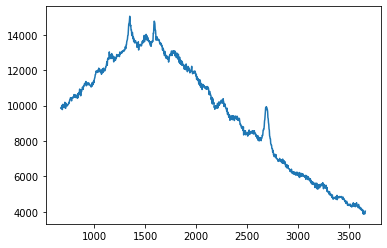

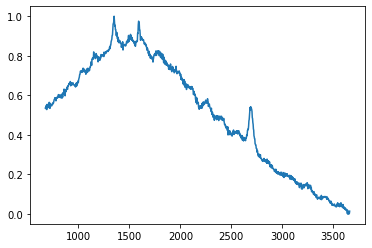

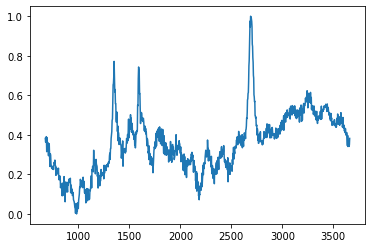

In [49]:
%matplotlib inline
plt.figure(0)
plt.plot(frequency, intensity)
plt.figure(1)
plt.plot(frequency, intensity_norm)
plt.figure(2)
plt.plot(frequency, I_BL)

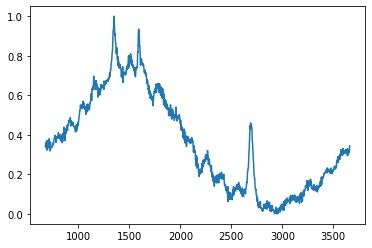

In [47]:
plt.plot(frequency, I_BL)

In [75]:
fpath = "C:/Users/Test/Documents/UIUC_Offline/Tool/Working/GSA-Raman\data\raw\spectest.csv"

import os
fpath = os.path.split(fpath)[-1]
fpath

'spectest.csv'